# Project 5 - Vehicle Detection

### Thomas J. Chmielenski

### October 3, 2017



In [1]:
### Perform a Histogram of Oriented Gradients (HOG) feature extraction on a 
### labeled training set of images and train a classifier Linear SVM classifier
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from random import randint
import numpy as np
import cv2
import glob
import os
import pickle
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

### Parameters

In [2]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32,32)  # Spatial binning dimensions
hist_bins = 32  # Number of histogram bins

spatial_feat = True # Spatial features on or off
hist_feat = True   # Histrogram feature on or off
hog_feat = True # HOG feeatures on or off
use_small_dataset = False

param_pickle = {}
param_pickle['color_space'] = color_space
param_pickle['orient'] = orient
param_pickle['pix_per_cell'] = pix_per_cell
param_pickle['cell_per_block'] = cell_per_block
param_pickle['hog_channel'] = hog_channel
param_pickle['spatial_size'] = spatial_size
param_pickle['hist_bins'] = hist_bins
param_pickle['spatial_feat'] = spatial_feat
param_pickle['hist_feat'] = hist_feat
param_pickle['hog_feat'] = hog_feat
param_pickle['use_small_dataset'] = use_small_dataset 
    
pickle.dump(param_pickle, open( "./parameters_pickle.p", "wb"))


def print_parameters ():
    print('color_space:', color_space)
    print('orient:', orient)
    print('pix_per_cell:', pix_per_cell)
    print('cell_per_block:', cell_per_block)
    print('hog_channel:', hog_channel)
    print('spatial_size:', spatial_size)
    print('hist_bins:', hist_bins)
    print('spatial_feat:', spatial_feat)
    print('hist_feat:', hist_feat)
    print('hog_feat:', hog_feat)
    print('use_small_dataset', use_small_dataset)

### Functions

In [3]:
def load_training_images(use_small_dataset = False):
    cars = []
    notcars = []

    # Read in our vehicles and non-vehicles
    if (use_small_dataset):
        images = glob.glob('training_images/small/**/*.jpeg', recursive=True)
        for image in images:
            basename = os.path.basename(image)
            if 'image' in basename or 'extra' in basename:
                notcars.append(image)
            else:
                cars.append(image)
    else:
        car_images = glob.glob('training_images/large/vehicles/**/*.png', recursive=True)
        for car_image in car_images:
            cars.append(car_image)
        notcar_images = glob.glob('training_images/large/non-vehicles/**/*.png', recursive=True)
        for notcar_image in notcar_images:
            notcars.append(notcar_image)

    return cars, notcars

def balance_classes(cars, notcars, verbose=False):
    # to prevent overfitting, make sure each set has the same number of items, 
    #   duplicate items if necessary.
    #  If you have a class imbalance, run the risk of the classifier
    #    trying to perdict everything as belonging to the majority class
    if (verbose):
        print("Before Class Balancing:")
        print ("  Number of Vehicles in training set: ", len(cars))
        print ("  Number of Non Vehicels in training set: ", len(notcars))

    if (len(cars) > len(notcars)):
        delta = len(cars) - len(notcars)
        for i in range(delta):
            pickRandomImage = randint(0, len(notcars)) -1
            notcars.append(notcars[pickRandomImage])
    elif (len(notcars) > len(cars)):
        delta = len(notcars) - len(cars)
        for i in range(delta):
            pickRandomImage = randint(0, len(cars)) -1
            cars.append(cars[pickRandomImage])
    
    if (verbose):
        print("\nAfter Class Balancing:")
        print ("  Number of Vehicles in training set: ", len(cars))
        print ("  Number of Non Vehicels in training set: ", len(notcars))
    
    return cars, notcars

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True, trans_sqrt=False):
    
    #print("get_hog_features: ", img.shape)
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=trans_sqrt, 
                                  visualise=vis, feature_vector=feature_vec, block_norm='L2-Hys')
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=trans_sqrt, 
                       visualise=vis, feature_vector=feature_vec, block_norm='L2-Hys')
        return features
    
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    #downsampling
    
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features
    #color1 = cv2.resize(img[:,:,0], size).ravel()
    #color2 = cv2.resize(img[:,:,1], size).ravel()
    #color3 = cv2.resize(img[:,:,2], size).ravel()
    #return np.hstack((color1, color2, color3))
    
    
# Define a function to compute color histogram features  
def color_hist(img, nbins=32):
    
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [5]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
#  This works for extracting features from a single image
#def single_img_features(image, color_space='RGB', spatial_size=(32, 32),
#                        hist_bins=32, orient=9, 
#                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
#                        spatial_feat=True, hist_feat=True, hog_feat=True,
#                        vis=False):
def single_img_features(image, color_space, spatial_size,
                        hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat,
                        vis=False):
    #can't set hog_channel to be "ALL", and vis="True"
    if (vis == True):
        assert hog_channel != "ALL", "Can't call hog_channel=ALL, when vis=True"
    
    img_features = []
        
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            assert 'colorspace: ' + color_space + 'is not valid!'
            
    else: 
        feature_image = np.copy(image)      

    # Apply bin_spatial() to get spatial color features
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)

    # Apply color_hist() also with a color space option now
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)

    if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        img_features.append(hog_features)

    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)
        

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
#  This works on multiple images
def extract_features(imgs, color_space, spatial_size,
                     hist_bins, orient, 
                     pix_per_cell, cell_per_block, hog_channel,
                     spatial_feat, hist_feat, hog_feat):

#def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
#                     hist_bins=32, orient=9, 
#                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
#                     spatial_feat=True, hist_feat=True, hog_feat=True):

    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for file in imgs:
        #print(file)
        img_features = []
        
        # Read in each one by one
        image = mpimg.imread(file)
        
         #### Uncomment the following line if you extracted training
        #### data from .png images (scaled 0 to 1 by mpimg) and the
        #### image you are searching is a .jpg (scaled 0 to 255)
        if (use_small_dataset):
            image = image.astype(np.float32)/255

        img_features = single_img_features(image, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=(hist_bins), orient=orient, 
                         pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                         spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=False)
        
        # Append the new features to the features list
        features.append(img_features)

    # Return list of feature vectors
    return features

In [6]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    
    # Return the list of windows
    return window_list


In [7]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
#def search_windows(img, windows, clf, scaler, color_space='RGB', 
#                    spatial_size=(32, 32), hist_bins=32, 
#                    hist_range=(0, 256), orient=9, 
#                    pix_per_cell=8, cell_per_block=2, 
#                    hog_channel=0, spatial_feat=True, 
#                    hist_feat=True, hog_feat=True):
def search_windows(img, windows, clf, scaler, color_space, 
                    spatial_size, hist_bins, 
                    orient, pix_per_cell, cell_per_block, 
                    hog_channel, spatial_feat, 
                    hist_feat, hog_feat):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        
        #features = single_img_features(test_img, color_space=color_space, 
        #                    spatial_size=spatial_size, hist_bins=hist_bins, 
        #                    orient=orient, pix_per_cell=pix_per_cell, 
        #                    cell_per_block=cell_per_block, 
        #                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
        #                    hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def convert_color(img, conv_to_colorspace):
    if conv_to_colorspace == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv_to_colorspace == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    if conv_to_colorspace == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv_to_colorspace == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

In [8]:
# Define a function for plottin multiple images
def plot_images(fig, rows, cols, imgs, titles, save_filename=None):
    for i, img in enumerate(imgs):
        plt.subplot(rows,cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])
    
    if save_filename:
        plt.savefig(save_filename)
    plt.show()

### Histogram of Oriented Gradients (HOG) Feature Extraction

In [9]:
%matplotlib inline

param_pickle = pickle.load(open( "./parameters_pickle.p", "rb"))
color_space = param_pickle['color_space']
orient = param_pickle['orient']
pix_per_cell = param_pickle['pix_per_cell']
cell_per_block = param_pickle['cell_per_block']
hog_channel = param_pickle['hog_channel']
spatial_size = param_pickle['spatial_size']
hist_bins = param_pickle['hist_bins']
spatial_feat = param_pickle['spatial_feat']
hist_feat = param_pickle['hist_feat']
hog_feat = param_pickle['hog_feat']
use_small_dataset = param_pickle['use_small_dataset']
    
cars, notcars = load_training_images(use_small_dataset = use_small_dataset)
cars, notcars = balance_classes(cars, notcars, verbose=True)

# Choose random vehicle / not - vehicle indeices
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# Read in vehicle / not vehicle images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

if use_small_dataset:
    car_image= car_image.astype(np.float32)/255
    notcar_image= notcar_image.astype(np.float32)/255

# Define feature parameters
vis = True

if hog_channel != 'ALL':
    car_features, car_hog_image =  single_img_features(car_image, color_space=color_space, spatial_size=spatial_size,
                            hist_bins=hist_bins, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                            spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=vis)

    notcar_features, notcar_hog_image =  single_img_features(notcar_image, color_space=color_space, spatial_size=spatial_size,
                            hist_bins=hist_bins, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                            spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=vis)


    visualize = True
    if visualize:
        images = [car_image, notcar_image]
        titles = ['Vehicle Image', 'Not Vehicle Image']
        fig = plt.figure(figsize=(12, 3), dpi=80)
        plot_images(fig, 1, 2, images, titles, save_filename="./output_images/car_notcar.png")


        images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
        titles = ['Vehicle Image', 'Vehicle HOG image','Not Vehicle Image', 'Non Vehicle HOG image']
        fig = plt.figure(figsize=(12, 3), dpi=80)
        plot_images(fig, 1, 4, images, titles, save_filename="./output_images/car_notcar_hog_images.png")




Before Class Balancing:
  Number of Vehicles in training set:  8792
  Number of Non Vehicels in training set:  8968

After Class Balancing:
  Number of Vehicles in training set:  8968
  Number of Non Vehicels in training set:  8968


### Spatial Binning

In [10]:
# Choose random vehicle / not - vehicle indeices
car_ind = np.random.randint(0, len(cars))

# Read in vehicle / not vehicle images
car_image = mpimg.imread(cars[car_ind])

# Define feature parameters
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
feature_image = cv2.cvtColor(car_image, cv2.COLOR_RGB2YCrCb)

feature_vec8 = bin_spatial(feature_image, size=(8, 8))
feature_vec16 = bin_spatial(feature_image, size=(16, 16))
feature_vec32 = bin_spatial(feature_image, size=(32, 32))
feature_vec64 = bin_spatial(feature_image, size=(64, 64))

# Plot features
visualize = False
if visualize:
    plt.title('Spatially Binned Features 8x8')
    plt.plot(feature_vec8)
    plt.savefig("./output_images/spatial_binning_8.png")
    plt.show()

    plt.title('Spatially Binned Features 16x16')
    plt.plot(feature_vec16)
    plt.savefig("./output_images/spatial_binning_16.png")
    plt.show()

    plt.title('Spatially Binned Features 32x32')
    plt.plot(feature_vec32)
    plt.savefig("./output_images/spatial_binning_32.png")
    plt.show()

    plt.title('Spatially Binned Features 64x64')
    plt.plot(feature_vec64)
    plt.savefig("./output_images/spatial_binning_64.png")
    plt.show()



### Color Histograms

In [11]:

# Choose random vehicle / not - vehicle indeices
car_ind = np.random.randint(0, len(cars))

# Read in vehicle / not vehicle images
car_image = mpimg.imread(cars[car_ind])

# Define feature parameters
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
feature_image = cv2.cvtColor(car_image, cv2.COLOR_RGB2YCrCb)

# Define a function to compute color histogram features  
def color_hist_by_color(img, nbins=32):
    # Compute the histogram of the RGB channels separately
    hist0 = np.histogram(img[:,:,0], bins=nbins)
    hist1 = np.histogram(img[:,:,1], bins=nbins)
    hist2 = np.histogram(img[:,:,2], bins=nbins)

    # Generating bin centers
    bin_edges = hist0[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2

    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((hist0[0], hist1[0], hist2[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return hist0, hist1, hist2, bin_centers, hist_features

visualize = False
if visualize:
    bins = [8, 16, 32, 64]
    for bin in bins:
        h0, h1, h2, bincen, feature_vec = color_hist_by_color(feature_image, nbins=bin)

        # Plot a figure with all three bar charts
        fig = plt.figure(figsize=(12,3))
        plt.subplot(131)
        plt.bar(bincen, h0[0])
        plt.xlim(0, 256)
        plt.title('Y Histogram: {} bins'.format(bin))
        plt.subplot(132)
        plt.bar(bincen, h1[0])
        plt.xlim(0, 256)
        plt.title('Cr Histogram: {} bins'.format(bin))
        plt.subplot(133)
        plt.bar(bincen, h2[0])
        plt.xlim(0, 256)
        plt.title('Cb Histogram: {} bins'.format(bin))
        fig.tight_layout()
        plt.savefig("./output_images/hist_bins_{}.png".format(bin))
        plt.show()
    



### Training the Classifier

In [12]:
param_pickle = pickle.load(open( "./parameters_pickle.p", "rb"))
color_space = param_pickle['color_space']
orient = param_pickle['orient']
pix_per_cell = param_pickle['pix_per_cell']
cell_per_block = param_pickle['cell_per_block']
hog_channel = param_pickle['hog_channel']
spatial_size = param_pickle['spatial_size']
hist_bins = param_pickle['hist_bins']
spatial_feat = param_pickle['spatial_feat']
hist_feat = param_pickle['hist_feat']
hog_feat = param_pickle['hog_feat']
vis = True

t=time.time()

use_subset = False
if (use_subset):
    n_samples = 1000
    random_idxs = np.random.randint(0, len(cars), n_samples)
    # need np.array to index like this
    test_cars = np.array(cars)[random_idxs]  #cars
    test_notcars = np.array(notcars)[random_idxs] #noncars
else:
    test_cars = cars
    test_notcars = notcars

car_features =  extract_features(test_cars, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(test_notcars, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

print(round(time.time()-t,2), 'Seconds to compute features....')

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per blockm ')
print('  ', hist_bins, 'histogram bins, and ', spatial_size, 'spatial sampling' )
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()

svm_pickle = {}
svm_pickle['svc'] = svc
svm_pickle['X_scaler'] = X_scaler
             
pickle.dump(svm_pickle, open( "./svm.p", "wb"))

144.13 Seconds to compute features....
Using: 9 orientations 8 pixels per cell and 2 cells per blockm 
   32 histogram bins, and  (32, 32) spatial sampling
Feature vector length: 8460
28.0 Seconds to train SVC...
Test Accuracy of SVC =  0.988


### Sliding Windows

2.86 seconds to process one image searching 273 windows
2.81 seconds to process one image searching 273 windows
2.77 seconds to process one image searching 273 windows
2.96 seconds to process one image searching 273 windows
2.82 seconds to process one image searching 273 windows
2.9 seconds to process one image searching 273 windows


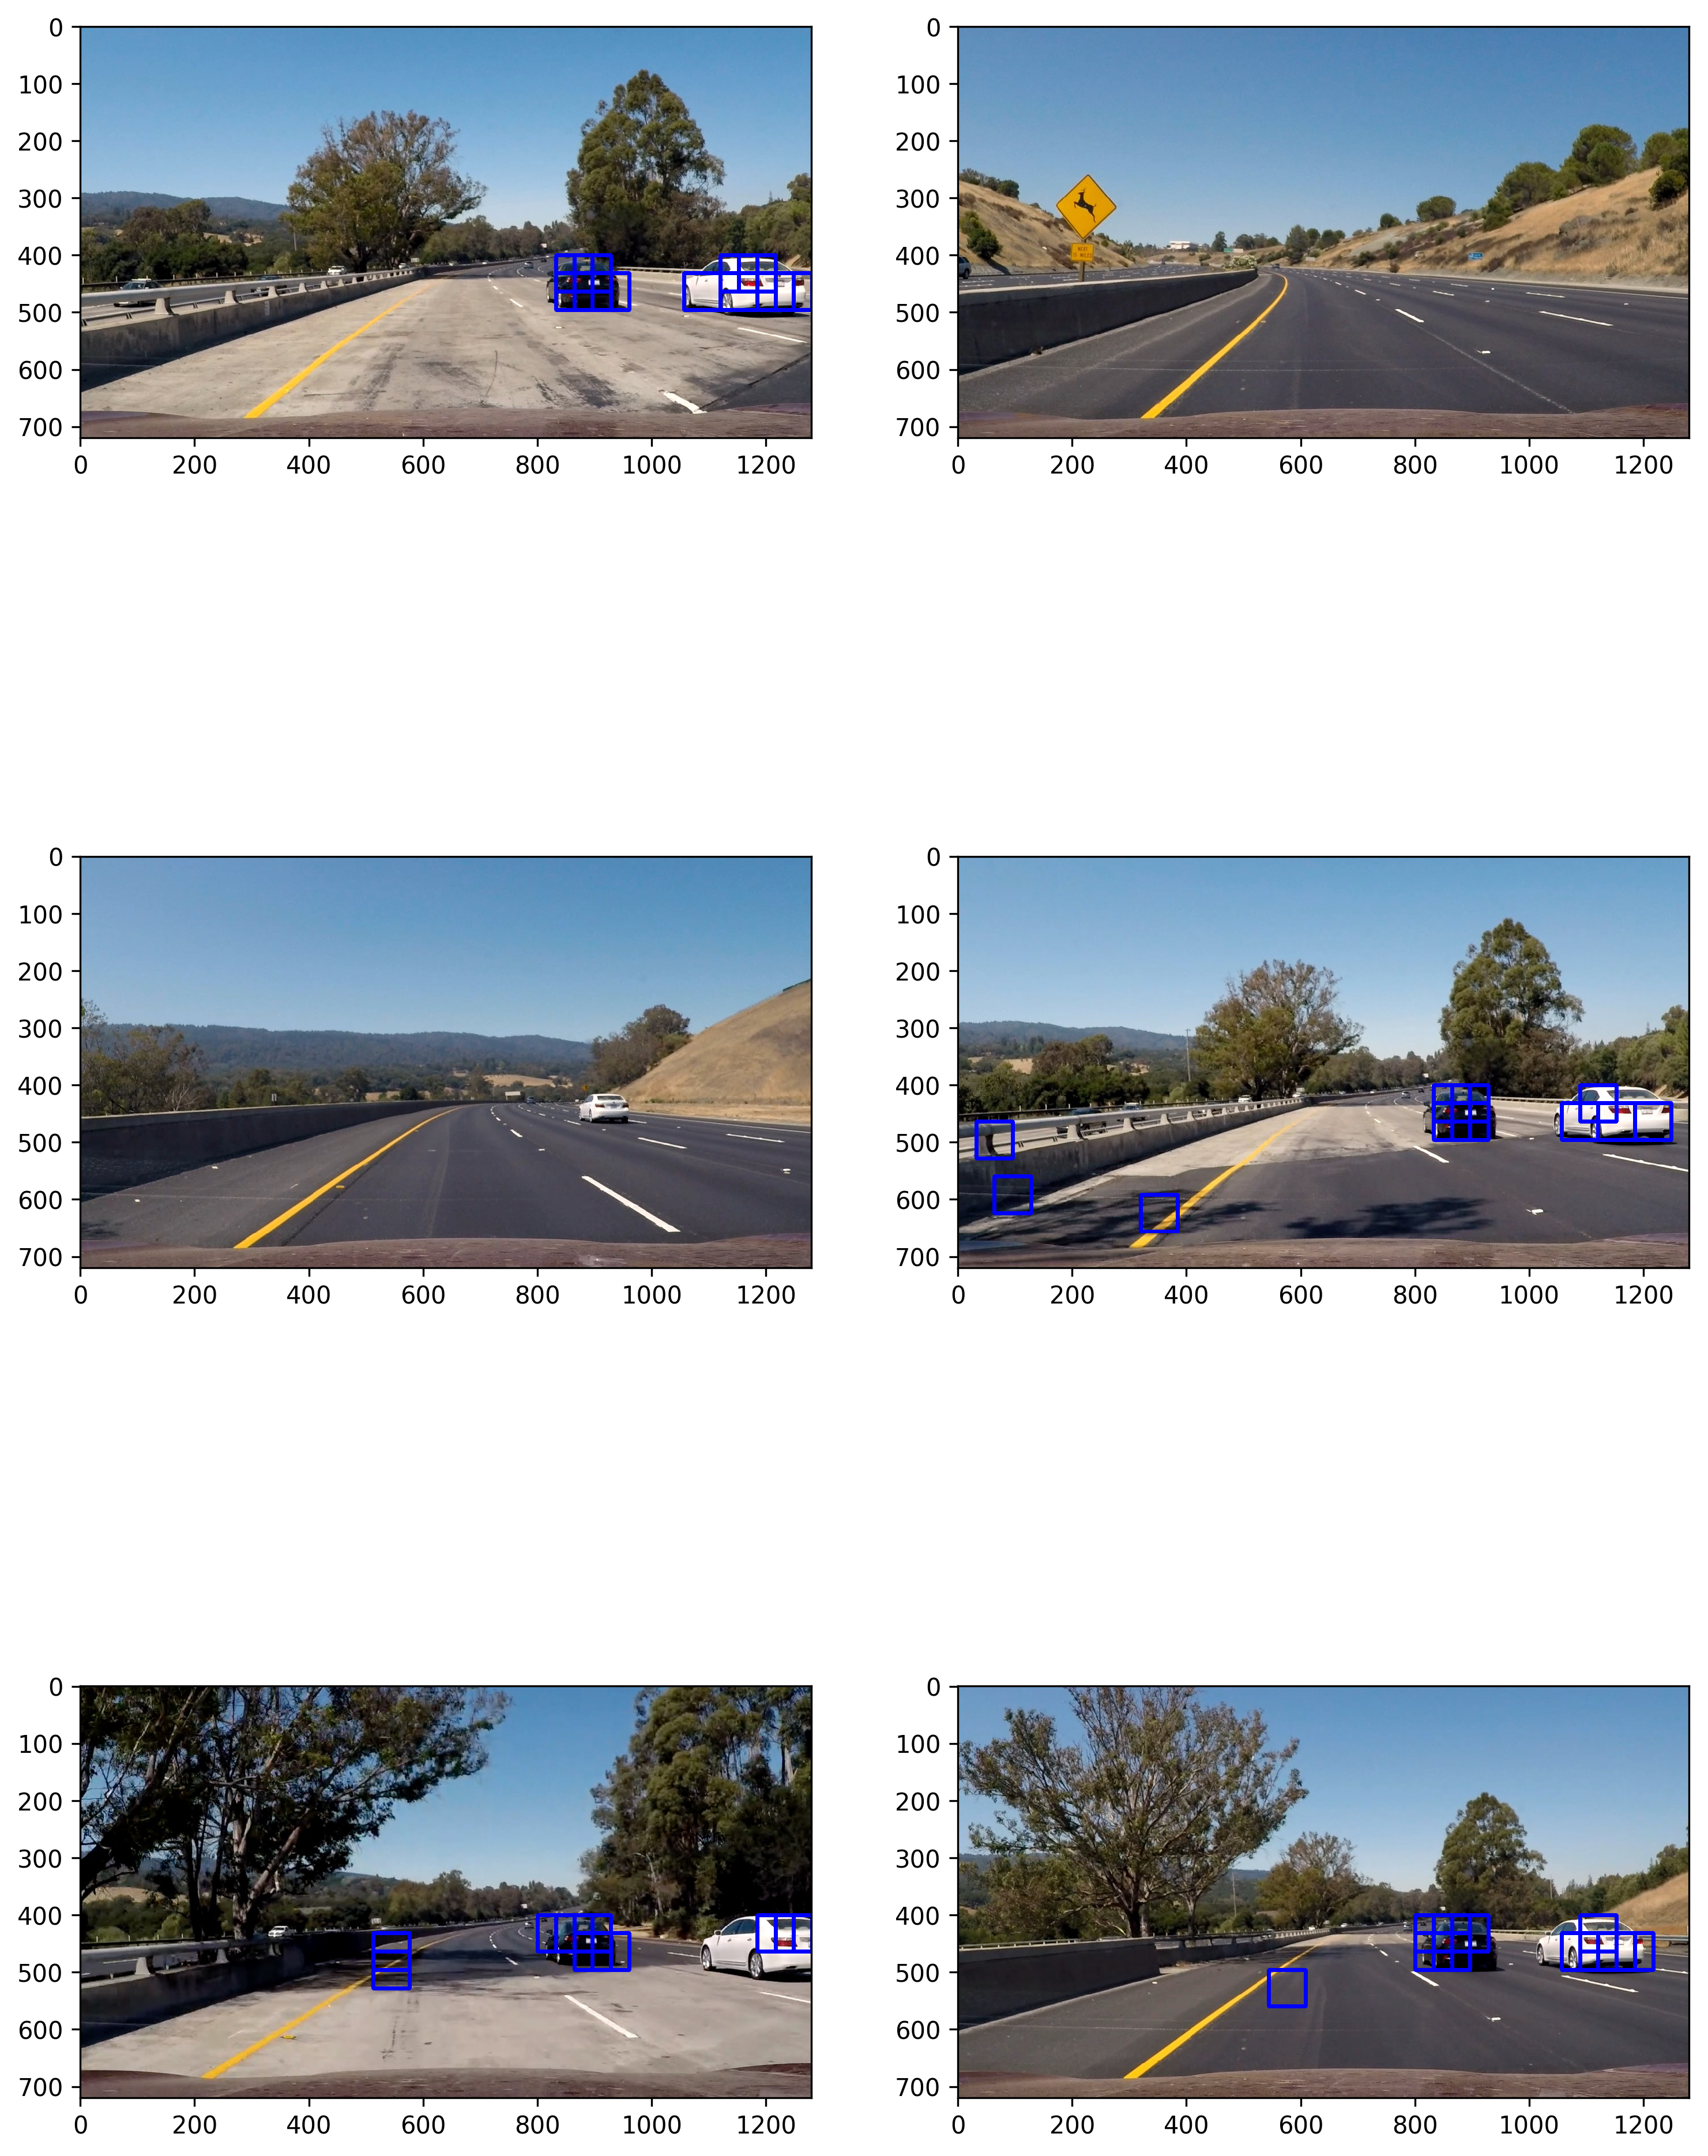

In [13]:
param_pickle = pickle.load(open( "./parameters_pickle.p", "rb"))
color_space = param_pickle['color_space']
orient = param_pickle['orient']
pix_per_cell = param_pickle['pix_per_cell']
cell_per_block = param_pickle['cell_per_block']
hog_channel = param_pickle['hog_channel']
spatial_size = param_pickle['spatial_size']
hist_bins = param_pickle['hist_bins']
spatial_feat = param_pickle['spatial_feat']
hist_feat = param_pickle['hist_feat']
hog_feat = param_pickle['hog_feat']


### Test on test images
test_images = glob.glob('test_images/*.jpg')
#test_images = glob.glob('test_frame_images/*.jpg')

images = []
titles = []
y_start_stop = [400,656] # Min and mazx in y to search in slide_window()
#y_start_stop = [None, None] # Min and mazx in y to search in slide_window()
overlap = 0.50

for img_file in  test_images:
    t1 = time.time()
    img = mpimg.imread(img_file)
    img_cpy = np.copy(img)
    
    #### Uncomment the following line if you extracted training
    #### data from .png images (scaled 0 to 1 by mpimg) and the
    #### image you are searching is a .jpg (scaled 0 to 255)
    img = img.astype(np.float32)/255
    #print(np.min(img), np.max(img))
    
    #windows1 = slide_window(img, x_start_stop=[None,None], y_start_stop=y_start_stop,
    #                       xy_window=(96,96), xy_overlap=(overlap,overlap))
    #windows2 = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
    #                xy_window=(64,64), xy_overlap=(overlap,overlap))
    #windows = windows1 + windows2
    windows = slide_window(img, x_start_stop=[None,None], y_start_stop=y_start_stop,
                           xy_window=(64,64), xy_overlap=(overlap,overlap))
    
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=colorspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(img_cpy, hot_windows, color=(0, 0, 255), thick=6)                    
    images.append(window_img)
    titles.append('')
    print(round(time.time()-t1,2), 'seconds to process one image searching', len(windows), 'windows')
    
#fig = plt.figure(figsize=(12, 3), dpi=80)
 
fig = plt.figure(figsize=(12,18), dpi=300)
plot_images (fig, 3, 2, images, titles, save_filename='./output_images/sliding_windows.png')


### Heatmaps

color_space: YCrCb
orient: 9
pix_per_cell: 8
cell_per_block: 2
hog_channel: ALL
spatial_size: (32, 32)
hist_bins: 32
spatial_feat: True
hist_feat: True
hog_feat: True
use_small_dataset False
0.43004608154296875 seconds to run, total windows =  144
0.5160031318664551 seconds to run, total windows =  144
0.4999980926513672 seconds to run, total windows =  144
0.47051239013671875 seconds to run, total windows =  144
0.44704556465148926 seconds to run, total windows =  144
0.4420642852783203 seconds to run, total windows =  144


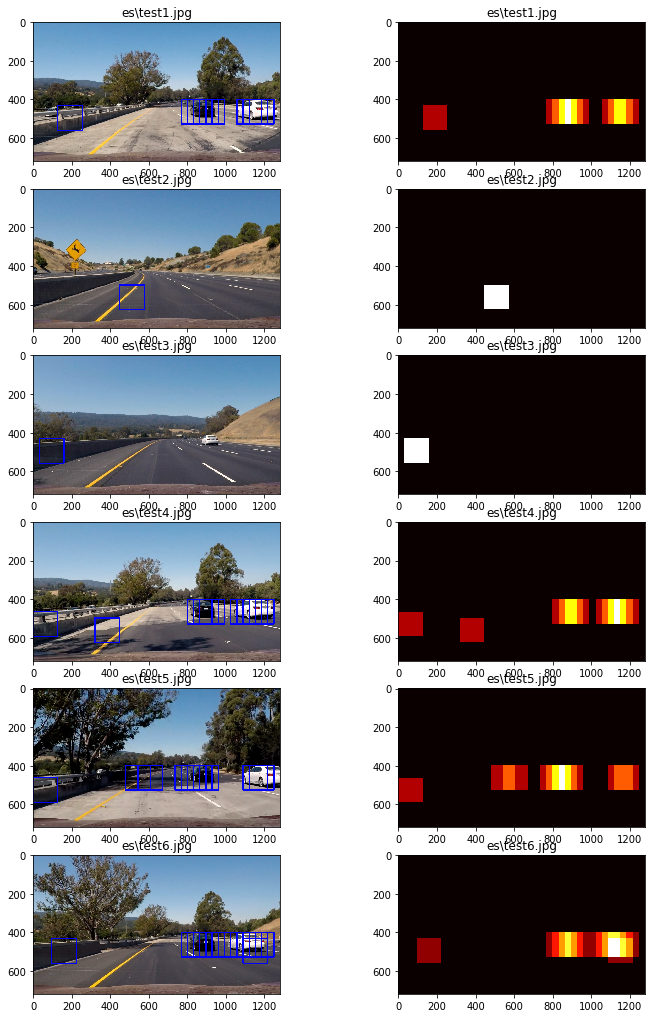

In [14]:
param_pickle = pickle.load(open( "./parameters_pickle.p", "rb"))
color_space = param_pickle['color_space']
orient = param_pickle['orient']
pix_per_cell = param_pickle['pix_per_cell']
cell_per_block = param_pickle['cell_per_block']
hog_channel = param_pickle['hog_channel']
spatial_size = param_pickle['spatial_size']
hist_bins = param_pickle['hist_bins']
spatial_feat = param_pickle['spatial_feat']
hist_feat = param_pickle['hist_feat']
hog_feat = param_pickle['hog_feat']

print_parameters()

out_images = []
out_maps = []
out_titles = []
out_boxes = []

#Consider a narrower swatch in y
ystart = 400
ystop = 656
scale = 2

# Iterate over test images
for img_file in test_images:
    img_boxes = []
    t = time.time()
    count = 0
    
    img = mpimg.imread(img_file)
    draw_img = np.copy(img)

    #Make a heatmap 
    heatmap = np.zeros_like(img[:,:,0])
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above  (hog cells)
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            
            count += 1
            
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            #hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            if hog_channel == 'ALL':
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            elif hog_channel == 0:
                hog_features = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            elif hog_channel == 1:
                hog_features =  hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            elif hog_channel == 2:
                hog_features = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((spatial_feat, hist_feat)).reshape(1, -1))    

            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                img_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1

    print (time.time()-t, 'seconds to run, total windows = ', count)

    out_images.append(draw_img)
    out_titles.append(img_file[-12:])
    out_titles.append(img_file[-12:])
    # heatmap = 255*heatmap/np.max(heatmap)
    out_images.append(heatmap)
    out_maps.append(heatmap)
    out_boxes.append(img_boxes)
    
fig = plt.figure(figsize=(12,24))
plot_images(fig, 8, 2, out_images, out_titles, save_filename="output_images/heatmap.png")

    

### Find Cars

In [15]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def find_cars2(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    bbox_list = []
    
    #Make a heatmap 
    #heatmap = np.zeros_like(img[:,:,0])

    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            #hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            if hog_channel == 'ALL':
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            elif hog_channel == 0:
                hog_features = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            elif hog_channel == 1:
                hog_features =  hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            elif hog_channel == 2:
                hog_features = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bbox = (xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)
                bbox_list.append(bbox)
                    
                #heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
                
    return draw_img, bbox_list

In [16]:
from scipy.ndimage.measurements import label

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

color_space: YCrCb
orient: 9
pix_per_cell: 8
cell_per_block: 2
hog_channel: ALL
spatial_size: (32, 32)
hist_bins: 32
spatial_feat: True
hist_feat: True
hog_feat: True
use_small_dataset False
2 cars found


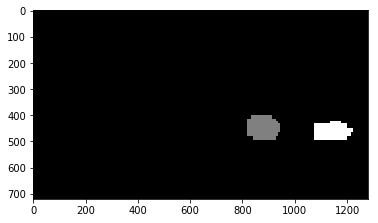

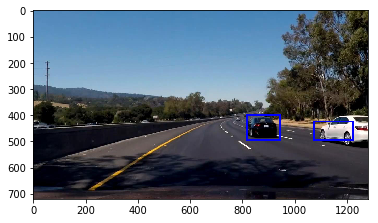

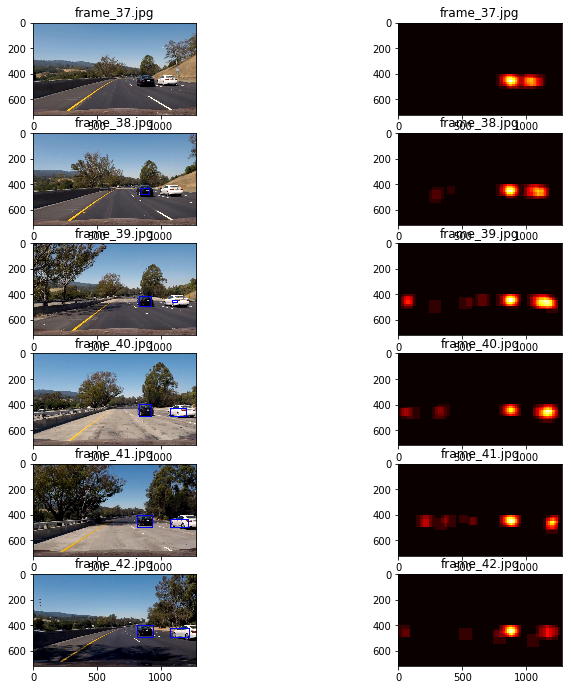

In [35]:
param_pickle = pickle.load(open( "./parameters_pickle.p", "rb"))
color_space = param_pickle['color_space']
orient = param_pickle['orient']
pix_per_cell = param_pickle['pix_per_cell']
cell_per_block = param_pickle['cell_per_block']
hog_channel = param_pickle['hog_channel']
spatial_size = param_pickle['spatial_size']
hist_bins = param_pickle['hist_bins']
spatial_feat = param_pickle['spatial_feat']
hist_feat = param_pickle['hist_feat']
hog_feat = param_pickle['hog_feat']

svm_pickle = pickle.load(open( "./svm.p", "rb"))
svc = svm_pickle['svc']
X_scaler = svm_pickle['X_scaler']
             
print_parameters()

threshold = 30
import collections
heatmaps = collections.deque(maxlen = 10)

out_images = []
out_titles = []

# Iterate over test frame images
images = glob.glob('test_frame_images/frame_*.jpg')
for idx, img_src in enumerate(images):

    img = mpimg.imread(img_src)

    filename =img_src.split("\\")
    out_titles.append(filename[1])
    out_titles.append(filename[1])

    img = mpimg.imread(img_src)

    # Create an empty heat map to draw on
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)

    frame_bbox_list = []
    bbox_list = []

    ystart = 400
    ystop = 528
    scale = 1.0
    out_img, bbox_list = find_cars2(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    frame_bbox_list += bbox_list

    ystart = 400
    ystop = 592
    scale = 1.5
    out_img, bbox_list = find_cars2(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    frame_bbox_list += bbox_list

    ystart = 496
    ystop = 656
    scale = 2.5
    out_img, bbox_list = find_cars2(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    frame_bbox_list += bbox_list

    heatmap = add_heat(heatmap, frame_bbox_list)
    heatmap = np.clip(heatmap, 0, 255)
    heatmaps.append(heatmap)
    sum_heatmaps = sum(heatmaps)
    thres_heatmap = apply_threshold(sum_heatmaps, threshold)
    labels = label(thres_heatmap)

    #Draw bounding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    #return draw_img
    out_images.append(draw_img)
    out_images.append(heatmap)

    
    if idx == 5:
        print(labels[1], 'cars found')
        plt.imshow(labels[0], cmap='gray')
        plt.savefig('output_images/frame6_labels_output.png')
        plt.show()
    
        plt.imshow(draw_img)
        plt.savefig('output_images/frame6_boundingboxes.png')
        plt.show()
        
fig = plt.figure(figsize = (12, 24))
filename = 'output_images/heatmaps_6frames.png'.format(i)
plot_images(fig, 12, 2, out_images, out_titles, save_filename=filename)
plt.show()

        
        
        


In [18]:
### Test on Videos
import os
import numpy as np

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def ensure_dir_exists(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

#def process_image(image):
#    # NOTE: The output you return should be a color image (3 channel) for processing video below
#    # TODO: put your pipeline here,
#    # you should return the final output (image where lines are drawn on lanes)
#   result = find_lanes_advanced(image)
#    return result

In [19]:
def process_image(img):
    
    # Create an empty heat map to draw on
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    
    frame_bbox_list = []
    bbox_list = []

    ystart = 400
    ystop = 528
    scale = 1.0
    out_img, bbox_list = find_cars2(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    frame_bbox_list += bbox_list
    #plt.imshow(out_img)
    #plt.show()

    ystart = 400
    ystop = 592
    scale = 1.5
    out_img, bbox_list = find_cars2(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    frame_bbox_list += bbox_list
    #plt.imshow(out_img)
    #plt.show()

    ystart = 496
    ystop = 656
    scale = 2.5
    out_img, bbox_list = find_cars2(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    frame_bbox_list += bbox_list

    heatmap = add_heat(heatmap, frame_bbox_list)
    heatmap = np.clip(heatmap, 0, 255)
    heatmaps.append(heatmap)
    sum_heatmaps = sum(heatmaps)
    thres_heatmap = apply_threshold(sum_heatmaps, threshold)
    labels = label(thres_heatmap)

    #Draw bounding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img
    

In [20]:
param_pickle = pickle.load(open( "./parameters_pickle.p", "rb"))
color_space = param_pickle['color_space']
orient = param_pickle['orient']
pix_per_cell = param_pickle['pix_per_cell']
cell_per_block = param_pickle['cell_per_block']
hog_channel = param_pickle['hog_channel']
spatial_size = param_pickle['spatial_size']
hist_bins = param_pickle['hist_bins']
spatial_feat = param_pickle['spatial_feat']
hist_feat = param_pickle['hist_feat']
hog_feat = param_pickle['hog_feat']

svm_pickle = pickle.load(open( "./svm.p", "rb"))
svc = svm_pickle['svc']
X_scaler = svm_pickle['X_scaler']

threshold = 30

print_parameters()

import collections
heatmaps = collections.deque(maxlen = 10)

#  Testing of test_video.mp4
#output_video = 'output_videos/test_video_output.mp4'
#clip1 = VideoFileClip("./test_video.mp4")
output_video = 'output_videos/project_video_output.mp4'
clip1 = VideoFileClip("./project_video.mp4")
#clip1 = VideoFileClip("./project_video.mp4").subclip(0-10)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_video, audio=False)
clip1.reader.close()
clip1.audio.reader.close_proc()

color_space: YCrCb
orient: 9
pix_per_cell: 8
cell_per_block: 2
hog_channel: ALL
spatial_size: (32, 32)
hist_bins: 32
spatial_feat: True
hist_feat: True
hog_feat: True
use_small_dataset False
[MoviePy] >>>> Building video output_videos/project_video_output.mp4
[MoviePy] Writing video output_videos/project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [30:49<00:01,  1.49s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_output.mp4 

Wall time: 30min 50s


In [ ]:
from IPython.display import HTML
HTML("""
<video width="960" height="540 controls>
    <source src="{0}">
</video>
""".format(output_video))

### Appendix A: Save frames of Video

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

#output_video = 'output_videos/project_video_output.mp4'
#ensure_dir_exists('./output_videos')
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("./project_video.mp4").subclip(0,50)


for t in range (1, 51, 1):
    filename = './test_frame_images/frame_' + str(t).zfill(2) + '.jpg'
    clip1.save_frame(filename, t=t, withmask=True)
    
    
clip1.reader.close()
clip1.audio.reader.close_proc()

### Appendix B:  Experimentation

In [ ]:
%matplotlib inline

cars, notcars = load_training_images()
cars, notcars = balance_classes(cars, notcars)

# Choose random vehicle / not - vehicle indeices
car_ind = np.random.randint(0, len(cars))

# Read in vehicle / not vehicle images
car_image = mpimg.imread(cars[car_ind])

# Define feature parameters
colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 6
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)  # Spatial binning dimensions
hist_bins = 16  # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True   # Histrogram feature on or off
hog_feat = True # HOG feeatures on or off
vis = True

#can't set hog_channel to be "ALL", and vis="True" w/ single_img_features


images = [car_image]
titles = ['Vehicle Image']

# Colorspace
colorspaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
for idx, cspace in enumerate(colorspaces):
    car_features, car_hog_image =  single_img_features(car_image, color_space=cspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)
   
    images.append(car_hog_image)
    titles.append (cspace)
    
fig = plt.figure(figsize=(12, 3), dpi=80)
visualize(fig, 2, 4, images, titles, save_filename="./output_images/hog_colorspace.png")



In [ ]:
colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 6
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)  # Spatial binning dimensions
hist_bins = 16  # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True   # Histrogram feature on or off
hog_feat = True # HOG feeatures on or off
vis = True

t=time.time()

use_subset = False
if (use_subset):
    n_samples = 1000
    random_idxs = np.random.randint(0, len(cars), n_samples)
    # need np.array to index like this
    test_cars = np.array(cars)[random_idxs]  #cars
    test_notcars = np.array(notcars)[random_idxs] #noncars
else:
    test_cars = cars
    test_notcars = notcars


count = 0

print("|", "cspace", "|","orient", "|","pix_per_cell", "|","cell_per_block", 
      "|","hog_channel", "|","spatial_size", "|","hist_bins", 
      "|","computeTime", "|","feature_length", "|","train_time", "|","accuracy","|")
print("|","---", "|","---", "|","---", "|","---", 
      "|","---", "|","---", "|","---", 
      "|","---", "|","---", "|","---", "|","---","|")
      
colorspaces = ['HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
for idx, cspace in enumerate(colorspaces):
    for orient in range (6,10):
        pix_per_cell = 8
        cell_per_block = 2
        
        for hog_channel in range(0,4):
            if hog_channel == 3:
                hog_channel = 'ALL'
        
            for iSize in range(0,2):
                if iSize == 0:
                    spatial_size = (16, 16)
                if iSize == 1:
                    spatial_size = (32, 32)

                for hSize in range(0,3):
                    if hSize == 0:
                        hist_bins = 16
                    if hSize == 1:
                        hist_bins = 32
                    if hSize == 2:
                        hist_bins = 64
                    count += 1 

                    car_features =  extract_features(test_cars, color_space=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

                    notcar_features = extract_features(test_notcars, color_space=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

                    computeTime = round(time.time()-t,2)
                    #print(time.time()-t, 'Seconds to compute features....')

                    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

                    # Fit a per-column scaler
                    X_scaler = StandardScaler().fit(X)

                    # Apply the scaler to X
                    scaled_X = X_scaler.transform(X)

                    # Define the labels vector
                    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

                    # Split up data into randomized training and test sets
                    rand_state = np.random.randint(0, 100)
                    X_train, X_test, y_train, y_test = train_test_split(
                                scaled_X, y, test_size=0.2, random_state=rand_state)

                    feature_length =len(X_train[0])
                    #print('Using:',orient,'orientations',pix_per_cell,
                    #    'pixels per cell and', cell_per_block,'cells per block')
                    #print('Feature vector length:', len(X_train[0]))

                    # Use a linear SVC 
                    svc = LinearSVC(C=0.5)

                    # Check the training time for the SVC
                    t=time.time()
                    svc.fit(X_train, y_train)
                    t2 = time.time()
                    train_time = round(t2-t,2)
                    #print(round(t2-t, 2), 'Seconds to train SVC...')

                    # Check the score of the SVC
                    accuracy = round(svc.score(X_test, y_test), 4)
                    #print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

                    # Check the prediction time for a single sample
                    t=time.time()

                    if accuracy > .9949:
                        print("")
                        print ("|",cspace, "|",orient, "|",pix_per_cell, "|",cell_per_block, 
                               "|",hog_channel, "|",spatial_size, "|",hist_bins, 
                              "|",computeTime, "|",feature_length, "|",train_time, "|",accuracy,"|")
    
print (count)